In [1]:
import pandas as pd
import numpy as np 
import glob as glob
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import skimage
from skimage.transform import rotate
from skimage.util import random_noise
from skimage.filters import gaussian
from skimage.transform import AffineTransform, warp
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,InputLayer,Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
import pandas as pd 
import numpy as np
import glob
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import cv2
import os  
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.layers import Dense,Flatten, Dropout
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras.optimizers import SGD, Adam

In [28]:
data=pd.read_csv("/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train.csv")
data.head()

NameError: name 'kaggle' is not defined

In [4]:
data.emergency_or_not.value_counts()

emergency_or_not
0    965
1    681
Name: count, dtype: int64

In [5]:
# create random number generator
seed = 45

In [6]:
# load images and store it in numpy array

# empty list to store the images
X = []
# iterating over each image
for img_name in data.image_names:
    # loading the image using its name
    img = plt.imread('/kaggle/input/emergency-vehicles-identification/Emergency_Vehicles/train/' + img_name)
    # normalizing the pixel values
    img = img/255
    # saving each image in the list
    X.append(img)
    
# converting the list of images into array
X=np.array(X)

# storing the target variable in separate variable
y = data.emergency_or_not.values

In [7]:
#shape of original dataset
X.shape

(1646, 224, 224, 3)

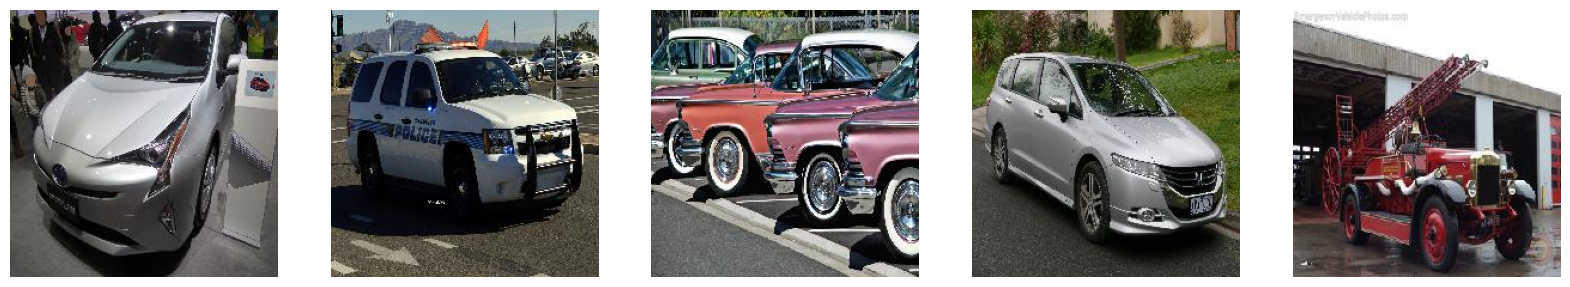

In [8]:
# visualizing images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(X[i*400])
    ax[i].axis('off')

## Creating traing and Validation set

In [9]:
# creating a training and validation set
X_train, X_valid, y_train, y_valid=train_test_split(X,y,test_size=0.3, random_state=seed)

In [10]:
#shape of traing and validation dataset
(X_train.shape,y_train.shape),(X_valid.shape,y_valid.shape)

(((1152, 224, 224, 3), (1152,)), ((494, 224, 224, 3), (494,)))

## Augmentation of Images

In [11]:
final_train_data=[]
final_target_data=[]
for i in tqdm(range(X_train.shape[0])):
    #original image
    final_train_data.append(X_train[i])
    #rotating the image
    final_train_data.append(rotate(X_train[i], angle=30, mode = 'edge'))
    #rotating left-right
    final_train_data.append(np.fliplr(X_train[i]))
    #rotating up-down
    final_train_data.append(np.flipud(X_train[i]))
    #add 25% of noise to the image
    final_train_data.append(random_noise(X_train[i],var=0.25))
    for j in range(5):
        final_target_data.append(y_train[i])

100%|██████████| 1152/1152 [00:11<00:00, 102.51it/s]


In [12]:
#converting imagers to target array 
final_train=np.array(final_train_data)
final_target_train=np.array(final_target_data)

In [13]:
# shape of new training set
final_train.shape, final_target_train.shape 

((5760, 224, 224, 3), (5760,))

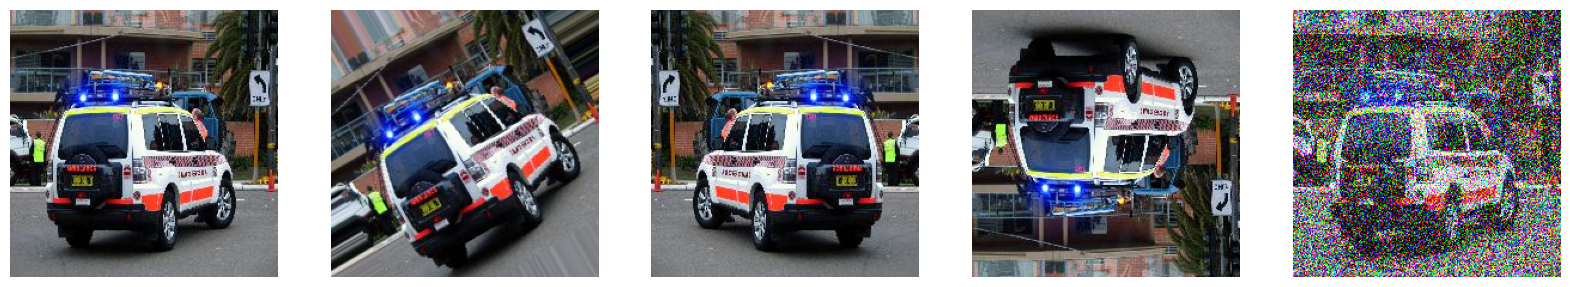

In [14]:
# visualizing the augmented images
fig,ax = plt.subplots(nrows=1,ncols=5,figsize=(20,20))
for i in range(5):
    ax[i].imshow(final_train[i+30])
    ax[i].axis('off')

In [15]:
# converting 3 dimensional image to 1 dimensional image
final_train = final_train.reshape(final_train.shape[0], 224*224*3)
final_train.shape

(5760, 150528)

In [16]:
# minimum and maximum pixel values of training images
final_train.min(), final_train.max()

(0.0, 1.0)

In [17]:
# converting 3 dimensional validation image to 1 dimensional image
final_valid = X_valid.reshape(X_valid.shape[0], 224*224*3)
final_valid.shape

(494, 150528)

In [18]:
# minimum and maximum pixel values of validation images
final_valid.min(), final_valid.max()

(0.0, 1.0)

# Defining Model Architecture

In [19]:
# defining the adam optimizer and setting the learning rate as 10^-5
adam = Adam(lr=1e-5)

In [20]:
# using relu as activation function in hidden layer
model=Sequential()
model.add(InputLayer(input_shape=(224*224*3,)))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.5))
model.add(Dense(100, activation='sigmoid'))
model.add(BatchNormalization())
model.add(Dropout(rate=0.4))
model.add(Dense(units=1,activation='sigmoid'))

# Compling and traing the model

In [21]:
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [22]:
model_history=model.fit(final_train,final_target_train,epochs=50,batch_size=150,validation_data=(final_valid,y_valid))

Epoch 1/50
58/58 [==============================] - 7s 54ms/step - loss: 0.8234 - accuracy: 0.5372 - val_loss: 0.6908 - val_accuracy: 0.5668
Epoch 2/50
58/58 [==============================] - 2s 35ms/step - loss: 0.7679 - accuracy: 0.5538 - val_loss: 0.6871 - val_accuracy: 0.5668
Epoch 3/50
58/58 [==============================] - 2s 35ms/step - loss: 0.7089 - accuracy: 0.5826 - val_loss: 0.6890 - val_accuracy: 0.5668
Epoch 4/50
58/58 [==============================] - 2s 36ms/step - loss: 0.6829 - accuracy: 0.5856 - val_loss: 0.6862 - val_accuracy: 0.5668
Epoch 5/50
58/58 [==============================] - 2s 35ms/step - loss: 0.6769 - accuracy: 0.5929 - val_loss: 0.6894 - val_accuracy: 0.5668
Epoch 6/50
58/58 [==============================] - 2s 36ms/step - loss: 0.6779 - accuracy: 0.5931 - val_loss: 0.6873 - val_accuracy: 0.5668
Epoch 7/50
58/58 [==============================] - 2s 35ms/step - loss: 0.6742 - accuracy: 0.5951 - val_loss: 0.6852 - val_accuracy: 0.5628
Epoch 8/50
58

In [23]:
#model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               15052900  
                                                                 
 batch_normalization (Batch  (None, 100)               400       
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               10100     
                                                                 
 batch_normalization_1 (Bat  (None, 100)               400       
 chNormalization)                                                
                                                                 
 dropout_1 (Dropout)         (None, 100)               0

# Evaluating the model

In [24]:
# Predict probabilities for each class
predicted_probabilities = model.predict(final_valid)

# Get predicted classes by finding the index of the maximum probability for each sample
predicted_classes = np.argmax(predicted_probabilities, axis=1)

16/16 [==============================] - 0s 10ms/step


In [25]:
# accuracy on validation set
print('Accuracy on validation set:', accuracy_score(y_valid, predicted_classes), '%')

Accuracy on validation set: 0.5668016194331984 %


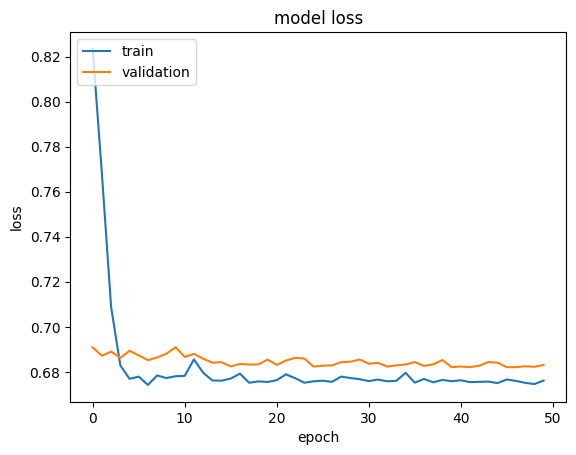

In [26]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

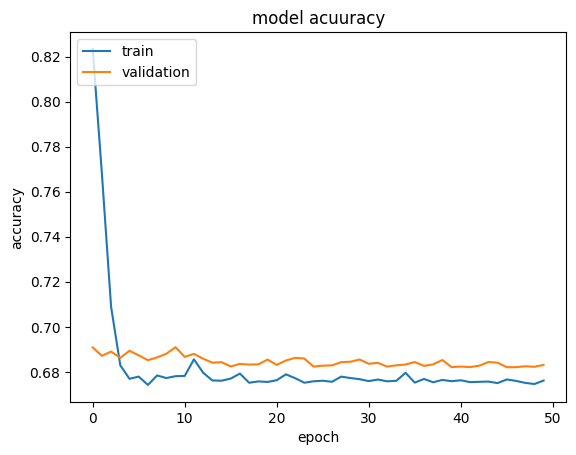

In [27]:
# summarize history for loss
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model acuuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()